## Mount on colab drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
DRIVE_PATH = '/content/drive/MyDrive/ML/hw5/dataset'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/dataset'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

## Import packages & define helper fns

In [3]:
import io
from collections import Counter

import numpy as np
import pandas as pd
import scipy.io
import sklearn.model_selection
import sklearn.tree
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pydot

In [4]:
eps = 1e-5  # a small number

def avg_surprise(y):
    total = len(y)
    labels = np.unique(y)
    h = 0
    for label in labels:
        p = np.sum(y == label)/total
        h += -p * np.log(p)
    return h
def gini_impurity(y):
    total = len(y)
    labels = np.unique(y)
    h = 0
    for label in labels:
        p = np.sum(y == label) / total
        h += -p * np.log(1-p)
    return h

    
def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == ''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i], keepdims=True).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features


def evaluate(clf):
    print("Cross validation", sklearn.model_selection.cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]
        print("First splits", first_splits)
        
def results_to_csv(y_test, name):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    df.to_csv(name+'.csv', index_label='Id')

## 4.1  Define Decision Trees

In [24]:
class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None, m=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.m = m
    @staticmethod
    def information_gain(X, y, thresh):
        # TODO: implement information gain function
        y_l = y[np.where(X>=thresh)]
        y_r = y[np.where(X<thresh)]
        h_after = (avg_surprise(y_l) * len(y_l) + avg_surprise(y_r) * len(y_r)) / len(y)
        return avg_surprise(y) - h_after
    @staticmethod
    # def gini_impurity(X, y, thresh):
    #     # TODO: implement gini impurity function
    #     pass
    def gini_gain(X, y, thresh):
        # TODO: implement gini impurity function
        y_l = y[np.where(X >= thresh)]
        y_r = y[np.where(X < thresh)]
        impurity_after = (gini_impurity(y_l) * len(y_l) + gini_impurity(y_r) * len(y_r)) / len(y)
        return avg_surprise(y) - impurity_after

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        if self.m:
            m_index = np.random.choice(list(range(X.shape[1])), self.m, replace=False)
            X_tmp = X[:, m_index]
        else:
            X_tmp = X
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            thresh = np.array([
                np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
                for i in range(X.shape[1])
            ])
            for i in range(X_tmp.shape[1]):
                gains.append([self.information_gain(X_tmp[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]

            if self.m:
                self.split_idx = m_index[self.split_idx]

            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y, keepdims=True).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y, keepdims=True).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat

    def __repr__(self):
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())

    def get_tree_structure(self):
      tree_str = "digraph Tree {\nnode [shape=box, fontname=\"helvetica\"] ;\nedge [fontname=\"helvetica\"] ;"
      tmp_str, _, _ = self.recursive_tree_str(0)
      tree_str += tmp_str
      tree_str += "\n}"
      return tree_str


    # return str, cur of current node, cur of the last traversed node in the branch
    def recursive_tree_str(self, cur):
      if self.max_depth == 0:
          return "\n%d [label = \"[%s (%s)]\"];" % (cur, self.pred, self.labels.size), cur, cur
      else:
          my_cur = cur
          base_str = "\n%d [label = \"%s < %s\"];" % (cur, self.features[self.split_idx], self.thresh)
          cur += 1
          l_str, l_cur , l_last_cur = self.left.recursive_tree_str(cur)
          cur = l_last_cur  + 1
          r_str, r_cur , r_last_cur = self.right.recursive_tree_str(cur)
          base_str += "\n%d -> %d;" % (my_cur, l_cur)
          base_str += "\n%d -> %d;" % (my_cur, r_cur)
          base_str += l_str + r_str
          return base_str, my_cur, r_last_cur

## 4.2 Define Random Forest

In [ ]:
class BaggedTrees(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None, sample_size=600, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.sp_size = sample_size
        self.decision_trees = [
            sklearn.tree.DecisionTreeClassifier(random_state=i, **self.params)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        # TODO: implement function
        dataset = np.concatenate((X,y.reshape(-1,1)), axis=1)
        for tree in self.decision_trees:
          index = np.random.choice(list(range(len(y))), self.sp_size, replace=True)
          tmp_dataset = dataset[index,:]
          X_rand = tmp_dataset[:, 0:-1]
          Y_rand = tmp_dataset[:, -1]
          # X_rand = tmp_dataset[0:sp_size, 0:-1]
          # Y_rand = tmp_dataset[0:sp_size, -1]
          tree.fit(X_rand, Y_rand)

    def predict(self, X):
        # TODO: implement function
        predictions = []
        for tree in self.decision_trees:
            predictions.append(tree.predict(X))
        return np.round(np.mean(predictions, axis=0))

class RandomForest(BaggedTrees):
    def __init__(self, params=None, sample_size=600, n=200, m=1, features=None):
        if params is None:
            params = {}
        # TODO: implement function
        self.params = params
        self.sp_size = sample_size
        self.n = n
        self.m = m
        self.decision_trees = [
            DecisionTree(max_depth=params["max_depth"], feature_labels=features, m=m)
            for i in range(self.n)
        ]

class BoostedRandomForest(RandomForest):
    def fit(self, X, y):
        self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
        self.a = np.zeros(self.n)  # Weights on decision trees
        # TODO: implement function
        return self

    def predict(self, X):
        # TODO: implement function
        pass


## Train on titanic

### (0) Load data

In [7]:
dataset = "titanic"
params = {
    "max_depth": 5,
    # "random_state": 6,
    "min_samples_leaf": 10,
}
N = 100

# Load titanic data
path_train = './dataset/titanic/titanic_training.csv'
data = genfromtxt(path_train, delimiter=',', dtype=None, encoding=None)
path_test = './dataset/titanic/titanic_test_data.csv'
test_data = genfromtxt(path_test, delimiter=',', dtype=None, encoding=None)
y = data[1:, -1]  # label = survived
class_names = ["Died", "Survived"]
labeled_idx = np.where(y != '')[0]

y = np.array(y[labeled_idx])
y = y.astype(float).astype(int)


print("\n\nPart (b): preprocessing the titanic dataset")
X, onehot_features = preprocess(data[1:, :-1], onehot_cols=[1, 5, 7, 8])
X = X[labeled_idx, :]
Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
assert X.shape[1] == Z.shape[1]
features = list(data[0, 1:]) + onehot_features

print("Features:", features)
print("Train/test size:", X.shape, Z.shape)




Part (b): preprocessing the titanic dataset
Features: ['sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'survived', 'male', 'female', '-1', 'S', 'C', 'Q']
Train/test size: (999, 15) (310, 15)


### (1) With decision Tree

In [ ]:
print("\n\nPart 0: constant classifier")
print("Accuracy", 1 - np.sum(y) / y.size)

# Basic decision tree
print("\n\nPart (a-b): simplified decision tree")
print("*****************************************************************************")
max_depths = [1, 5, 10, 20, 30, 40]
# max_depths = [1, 3, 5, 7, 10, 20]
train_acc_list = []
val_acc_list = []
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=13)

for depth in max_depths:
    dt = DecisionTree(max_depth=depth, feature_labels=features)
    dt.fit(X_train, Y_train)
    predict_train = dt.predict(X_train)
    predict_val = dt.predict(X_val)
    train_acc = accuracy_score(Y_train, predict_train)
    train_acc_list.append(train_acc)
    val_acc = accuracy_score(Y_val, predict_val)
    print(f"For depth {depth}: train acc is {train_acc:.2f}, val acc is {val_acc:.2f}")
    val_acc_list.append(val_acc)

plt.plot(max_depths, train_acc_list, label="train_acc")
plt.plot(max_depths, val_acc_list, label="val_acc")
plt.title("Titanic: training & validation accuracy curve over max_depth")
plt.xlabel("max_depth")
plt.ylabel("Acc")
plt.legend()
plt.show()
print("*****************************************************************************")

# dt = DecisionTree(max_depth=3, feature_labels=features)
# dt.fit(X, y)
# print("Predictions", dt.predict(Z)[:100])

print("\n\nPart (c): sklearn's decision tree")
clf = sklearn.tree.DecisionTreeClassifier(random_state=0, **params)
clf.fit(X, y)
evaluate(clf)
out = io.StringIO()

# You may want to install "gprof2dot"
sklearn.tree.export_graphviz(
    clf, out_file=out, feature_names=features, class_names=class_names)
graph = pydot.graph_from_dot_data(out.getvalue())
pydot.graph_from_dot_data(out.getvalue())[0].write_pdf("%s-tree.pdf" % dataset)

# TODO: implement and evaluate!




Part 0: constant classifier
Accuracy 0.6166166166166166


Part (a-b): simplified decision tree
*****************************************************************************
For depth 1: train acc is 0.78, val acc is 0.80
For depth 5: train acc is 0.83, val acc is 0.81


KeyboardInterrupt: ignored

### (2) With random forest

For m 1: train acc is 0.61, val acc is 0.62
For m 2: train acc is 0.82, val acc is 0.80
For m 3: train acc is 0.82, val acc is 0.80
For m 5: train acc is 0.82, val acc is 0.80
For m 7: train acc is 0.82, val acc is 0.81
For m 9: train acc is 0.82, val acc is 0.81


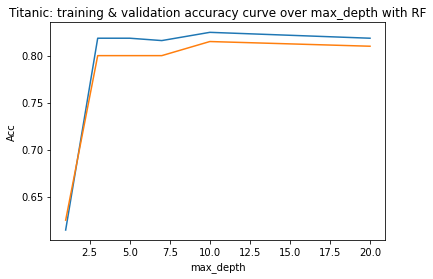

In [ ]:
np.random.seed(13)
m_list = [1, 2, 3, 5, 7, 9]
train_acc_list = []
val_acc_list = []
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=13)
for m in m_list:
    dt = RandomForest(params, sample_size=300, m=m, features=features)
    dt.fit(X_train, Y_train)
    predict_train = dt.predict(X_train)
    predict_val = dt.predict(X_val)
    train_acc = accuracy_score(Y_train, predict_train)
    train_acc_list.append(train_acc)
    val_acc = accuracy_score(Y_val, predict_val)
    print(f"For m {m}: train acc is {train_acc:.2f}, val acc is {val_acc:.2f}")
    val_acc_list.append(val_acc)

plt.plot(max_depths, train_acc_list, label="train_acc")
plt.plot(max_depths, val_acc_list, label="val_acc")
plt.title("Titanic: training & validation accuracy curve over max_depth with RF")
plt.xlabel("max_depth")
plt.ylabel("Acc")
plt.show()

### (3) Best perf

In [25]:
dt = DecisionTree(max_depth=7, feature_labels=features)
dt.fit(X, y)
predict_test = dt.predict(Z)
results_to_csv(predict_test, "decision_tree_titanic")

# dt = RandomForest(params, sample_size=300, m=7, features=features)
# dt.fit(X, y)
# predict_test = dt.predict(Z)
# results_to_csv(predict_test, "random_forest_titanic")

### (4) Visualize

In [26]:
print(dt)
print(dt.get_tree_structure())

[male < 1e-05: [sex < 2.11111: [S < 1e-05: [sibsp < 49.55555: [sex < 1.00001: 1 (48) | 1 (10)] | [sibsp < 50.00001: [ticket < 1e-05: 0 (1) | 1 (1)] | 1 (10)]] | [sibsp < 58.888883333333325: [sex < 1.00001: [ticket < 1.11111: 1 (41) | [sibsp < 2.00001: 0 (1) | 1 (11)]] | [sibsp < -0.99999: 0 (1) | [sibsp < 56.99999: 1 (62) | 0 (1)]]] | [sex < 1.00001: [cabin < 79.09445000000001: 1 (3) | [sibsp < 60.00001: 1 (1) | 0 (1)]] | 0 (1)]]] | [cabin < 27.683336666666666: [S < 1e-05: [cabin < 15.916665555555555: [cabin < 6.75001: 0 (1) | [cabin < 13.787983333333333: 1 (40) | 0 (18)]] | 1 (7)] | [-1 < 1e-05: 1 (4) | [cabin < 23.414836666666666: [sibsp < 48.777772222222225: 0 (74) | 1 (1)] | 0 (4)]]] | [cabin < 32.52778555555555: [cabin < 31.38749: 0 (5) | 1 (2)] | 0 (11)]]] | [-1 < 1e-05: [cabin < 284.6273322222222: [cabin < 175.33333000000005: [parch < 1e-05: [cabin < 34.102783333333335: [cabin < 7.560183333333332: 0 (4) | 0 (39)] | [ticket < 1.11111: 0 (23) | 1 (3)]] | [sibsp < 14.04632777777777

In [27]:
# print(dt.get_tree_structure())
dt = DecisionTree(max_depth=2, feature_labels=features)
dt.fit(X, y)
predict_test = dt.predict(Z)
results_to_csv(predict_test, "decision_tree_titanic")
# graph = pydot.graph_from_dot_data(dt.get_tree_structure())
pydot.graph_from_dot_data(dt.get_tree_structure())[0].write_pdf("%s-mytree.pdf" % dataset)

## Train on spam

### (0) Load data

In [ ]:
dataset = "spam"
params = {
    "max_depth": 5,
    # "random_state": 6,
    "min_samples_leaf": 10,
}
N = 100

features = [
    "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
    "height", "featured", "differ", "width", "other", "energy", "business", "message",
    "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
    "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
    "ampersand"
]
assert len(features) == 32

# Load spam data
path_train = './dataset/spam/spam_data.mat'
data = scipy.io.loadmat(path_train)
X = data['training_data']
y = np.squeeze(data['training_labels'])
Z = data['test_data']
class_names = ["Ham", "Spam"]


print("Features:", features)
print("Train/test size:", X.shape, Z.shape)

Features: ['pain', 'private', 'bank', 'money', 'drug', 'spam', 'prescription', 'creative', 'height', 'featured', 'differ', 'width', 'other', 'energy', 'business', 'message', 'volumes', 'revision', 'path', 'meter', 'memo', 'planning', 'pleased', 'record', 'out', 'semicolon', 'dollar', 'sharp', 'exclamation', 'parenthesis', 'square_bracket', 'ampersand']
Train/test size: (5280, 32) (5749, 32)


### (1) With decision Tree



Part 0: constant classifier
Accuracy 0.7238979118329467


Part (a-b): simplified decision tree
For depth 1: train acc is 0.74, val acc is 0.76
For depth 5: train acc is 0.82, val acc is 0.82
For depth 10: train acc is 0.85, val acc is 0.83
For depth 15: train acc is 0.87, val acc is 0.83
For depth 20: train acc is 0.89, val acc is 0.82


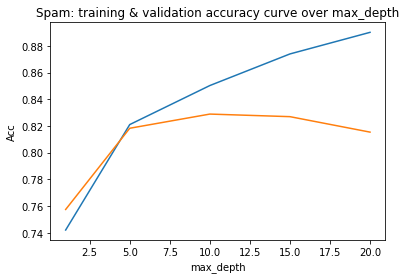

*****************************************************************************


Part (c): sklearn's decision tree
Cross validation [0.80772947 0.80772947 0.80754352 0.82011605 0.81237911]


In [ ]:
print("\n\nPart 0: constant classifier")
print("Accuracy", 1 - np.sum(y) / y.size)

# Basic decision tree
print("\n\nPart (a-b): simplified decision tree")
max_depths = [1, 5, 10, 15, 20]
train_acc_list = []
val_acc_list = []
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=13)

for depth in max_depths:
    dt = DecisionTree(max_depth=depth, feature_labels=features)
    dt.fit(X_train, Y_train)
    predict_train = dt.predict(X_train)
    predict_val = dt.predict(X_val)
    train_acc = accuracy_score(Y_train, predict_train)
    train_acc_list.append(train_acc)
    val_acc = accuracy_score(Y_val, predict_val)
    print(f"For depth {depth}: train acc is {train_acc:.2f}, val acc is {val_acc:.2f}")
    val_acc_list.append(val_acc)

plt.plot(max_depths, train_acc_list, label="train_acc")
plt.plot(max_depths, val_acc_list, label="val_acc")
plt.title("Spam: training & validation accuracy curve over max_depth")
plt.xlabel("max_depth")
plt.ylabel("Acc")
plt.show()
print("*****************************************************************************")

# dt = DecisionTree(max_depth=3, feature_labels=features)
# dt.fit(X, y)
# print("Predictions", dt.predict(Z)[:100])

print("\n\nPart (c): sklearn's decision tree")
clf = sklearn.tree.DecisionTreeClassifier(random_state=0, **params)
clf.fit(X, y)
evaluate(clf)
out = io.StringIO()

# You may want to install "gprof2dot"
sklearn.tree.export_graphviz(
    clf, out_file=out, feature_names=features, class_names=class_names)
graph = pydot.graph_from_dot_data(out.getvalue())
pydot.graph_from_dot_data(out.getvalue())[0].write_pdf("%s-tree.pdf" % dataset)

### (2) With random forest

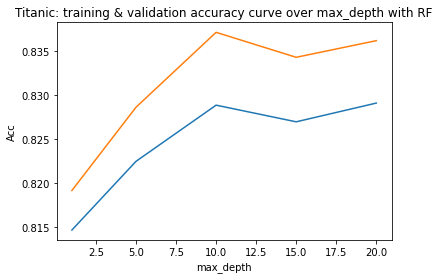

In [ ]:
np.random.seed(13)
m_list = [1, 5, 10, 15, 20]
train_acc_list = []
val_acc_list = []
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=13)
for m in m_list:
    dt = RandomForest(params, sample_size=300, m=m, features=features)
    dt.fit(X_train, Y_train)
    predict_train = dt.predict(X_train)
    predict_val = dt.predict(X_val)
    train_acc = accuracy_score(Y_train, predict_train)
    train_acc_list.append(train_acc)
    val_acc = accuracy_score(Y_val, predict_val)
    print(f"For m {m}: train acc is {train_acc:.2f}, val acc is {val_acc:.2f}")
    val_acc_list.append(val_acc)

plt.plot(max_depths, train_acc_list, label="train_acc")
plt.plot(max_depths, val_acc_list, label="val_acc")
plt.title("Titanic: training & validation accuracy curve over max_depth with RF")
plt.xlabel("max_depth")
plt.ylabel("Acc")
plt.show()

### (3) Best perf

In [ ]:
dt = DecisionTree(max_depth=15, feature_labels=features)
dt.fit(X, y)
predict_test = dt.predict(Z)
results_to_csv(predict_test, "decision_tree_spam")

# dt = RandomForest(params, sample_size=300, m=10, features=features)
# dt.fit(X, y)
# predict_test = dt.predict(Z)
# results_to_csv(predict_test, "random_forest_spam")